In this notebook I run statistical learning models on residential home sales in the Bell school area of Chicago, a highly gentrifying neighborhood with a large number of flipping and teardowns, to demonstrate that models with no inherent bias in their method lead to biased results, overvaluing low priced homes and undervaluing high priced homes. This is not surprising since it is a basic property of models based on averaging. The problem, regression towards the mean, is so intrinsic to these methods that the basic method bares its name. This property exasperates inequality as it leads to lesser taxation of wealthy people and higher taxation on poor people. The results could be used to advocate for a transition from property tax to income tax as was recently attempted in Illinois.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
#from library.sb_utils import save_file
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import pickle
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
bell_sales = pd.read_csv('../data/bell_sales_cleaned.csv')

In [3]:
bell_sales['one_story'] = [1 if x < 205 else 0 for x in bell_sales['meta_class']]
bell_sales['row_house'] = [1 if ((x == 210) or (x==295)) else 0 for x in bell_sales['meta_class']]
bell_sales.head()

,Unnamed: 0,meta_pin,meta_year,meta_class,meta_sale_price,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house
0,126575,13242020170000,2017.0,278,850000.0,3050.0,18.0,8.0,4.0,0.0,2.0,1.0,2340.0,-87.690565,41.953323,0,0
1,126576,13242020180000,2013.0,278,1055000.0,3050.0,2.0,9.0,4.0,3.0,3.0,1.0,2639.0,-87.690473,41.953324,0,0
2,126578,13242030020000,2013.0,203,330000.0,3137.0,54.0,6.0,3.0,0.0,2.0,0.0,1020.0,-87.690731,41.952804,1,0
3,126579,13242030040000,2014.0,202,300000.0,3050.0,116.0,4.0,2.0,0.0,2.0,0.0,680.0,-87.690547,41.952805,1,0
4,126580,13242030110000,2018.0,206,976711.0,3660.0,96.0,7.0,4.0,1.0,2.0,1.0,2778.0,-87.689729,41.952810,0,0


In [4]:
bell_sales_pin = bell_sales.meta_pin
bell_y = bell_sales.meta_sale_price
bell_X = bell_sales.drop(['Unnamed: 0','meta_pin','meta_sale_price','meta_class'],axis=1)

In [5]:
bell_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   meta_year      293 non-null    float64
 1   char_hd_sf     293 non-null    float64
 2   char_age       293 non-null    float64
 3   char_rooms     293 non-null    float64
 4   char_beds      293 non-null    float64
 5   char_frpl      293 non-null    float64
 6   char_fbath     293 non-null    float64
 7   char_hbath     293 non-null    float64
 8   char_bldg_sf   293 non-null    float64
 9   geo_longitude  293 non-null    float64
 10  geo_latitude   293 non-null    float64
 11  one_story      293 non-null    int64  
 12  row_house      293 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 29.9 KB


meta_class is the cook county classification of each property based on age, squarefootage, number of stories, and if it is detached or attached to other homes. As age and square footage are seperate feautures, the useful info to extract from the class are the number of stories and if it is attached.

In [6]:
columns=bell_X.columns

In [7]:
X_train, X_test, y_train, y_test = train_test_split(bell_X, bell_y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaling is needed for models that need to determine a 'distance" between data points. But for models, such as decesion trees, that do not require a distance, it is not required.Scaling should do no harm when it is not needed. 

First just try metrics for the mean value of the training data

In [9]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train,y_train)
dumb_reg.constant_



array([[1131707.35042735]])

In [10]:
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = dumb_reg.predict(X_test)
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.44996805776414805,
 0.4638872851774428,
 0.0,
 -0.006717921520868142,
 434738.2204517969,
 462579.2947234855,
 347035.00387172186,
 375599.8958423874)

Three metrics recommended by the International association of assessing officers based on the ratio y_pred/y_test are Coefficient of Dispersion (COD), Price Related Differential (PRD), and Coefficent of Price-Related Bias.

Coefficient of Dispersion (COD)is a measure of the variance of the ratio. It is multiplied by 100. Its value is the percentage variation of the ratio away from the median. It does not tell us if low priced homes are being treated differently than high priced homes.

In [11]:
def cod(y_pred,y_test):
    ratio = y_pred/y_test
    ratio_median = np.median(ratio)
    return 100*np.mean(np.abs(ratio-ratio_median))/ratio_median
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(44.46304068614593, 40.43873536375696)

Just taking an average produces a variation of over 40% is the ratio.


Price Related Differential does tell us if low priced homes are being treated differently than high priced homes. It is the mean ratio divided by the sales price weighted mean ratio. If the ratio for large sales price homes is lower than the ratio for low sales price homes, then the mean ratio over the weighted mean ratio will be larger than 1.

In [12]:
def prd(y_pred,y_test):
    ratio = y_pred/y_test
    y_test_sum = np.sum(y_test)
    y_pred_sum = np.sum(y_pred)
    return np.mean(ratio)*y_test_sum/y_pred_sum
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.2397913651988004, 1.2271569281135832)

The mean ratio is 22% higher than the weighted mean ratio, indicating that low proced homes are priced higher than their sales price compared to how high priced homes are treated.  This is a consequence that small variations in the predicated price of a low priced home makes a bigger change in the ratio.

Coefficent of price related bias (PRB) does a liner regression between the log2 of the price and the ratio. A negative number means that if one increases the price, the ratio goes down.

In [13]:
def prb(y_pred,y_test):
    proxy = 0.5*(y_pred + y_test)
    ln_value = pd.DataFrame(np.log2(proxy))
    ratio = y_pred/y_test
    ratio_median = np.median(ratio)
    pct_dif = (ratio - ratio_median)/ratio_median
    lr = LinearRegression()
    lr.fit(ln_value,pct_dif)
    return lr.coef_
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-2.30460326]), array([-1.77788597]))

Using the average price for all predictions has the consequence that doubling the price of the home means the ratio goes down by 178%.

Next we see how linear regression improves predicted prices.  

In [14]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [15]:
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [16]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.17024646373122818,
 0.20877836527125762,
 0.7986853029158377,
 0.6026764394678505,
 195058.80726145208,
 290605.91452558845,
 153166.36786171395,
 213838.31583288126)

In [17]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(16.842064162217586, 19.13095426729003)

variance is cut by more than half

In [18]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0468692430716888, 1.065616774119676)

mean ratio is now only 7 percent higher than the weighted ratio.

In [19]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.13606587]), array([-0.13707227]))

<AxesSubplot:xlabel='meta_sale_price'>

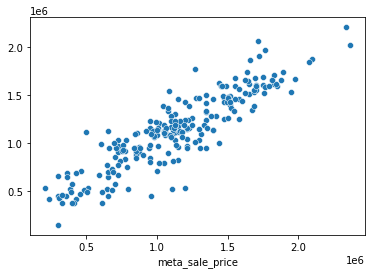

In [20]:
sns.scatterplot(x=y_train,y=y_tr_pred)

<AxesSubplot:xlabel='meta_sale_price'>

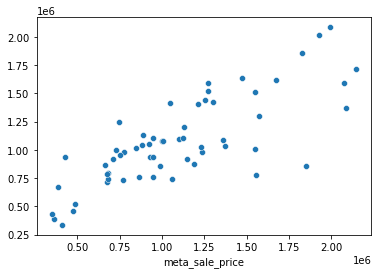

In [21]:
sns.scatterplot(x=y_test,y=y_te_pred)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

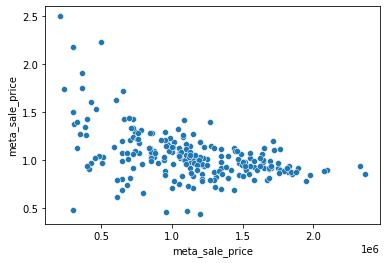

In [22]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

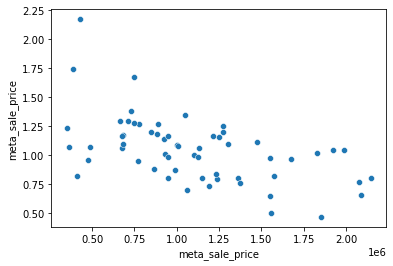

In [23]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

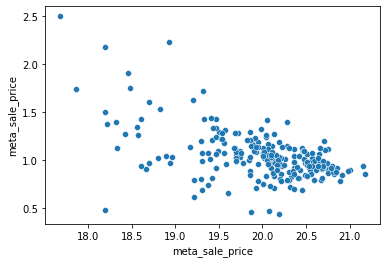

In [24]:
sns.scatterplot(x=np.log2(y_train),y=y_tr_pred/y_train)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

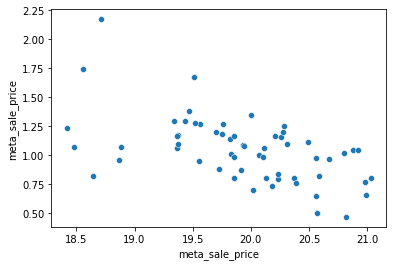

In [25]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

For linear regression, doubling the home price means the ratio goes down by almost 14%. Let's see how much this can be improved with ElasticNet which includes LinearRegression as a limit.

In [26]:
en = ElasticNet()

In [27]:
params = {'alpha':[0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,3823.315949420067],'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}
en_gscv = GridSearchCV(en,params,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")

In [28]:
en_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 3823.315949420067],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_absolute_percentage_error')

In [29]:
y_tr_pred = en_gscv.predict(X_train)
y_te_pred = en_gscv.predict(X_test)

In [30]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.1711951045179366,
 0.20624881477524473,
 0.7975631366516762,
 0.6095832836919701,
 195601.69914175628,
 288068.9780029611,
 155054.72246117293,
 211545.74411722185)

In [31]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(16.77928581591395, 18.948552969510658)

In [32]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0491360566949972, 1.0671990691429285)

In [33]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.14880359]), array([-0.14911457]))

In [34]:
en_gscv.best_params_

{'alpha': 0.1, 'l1_ratio': 0.7}

<AxesSubplot:xlabel='meta_sale_price'>

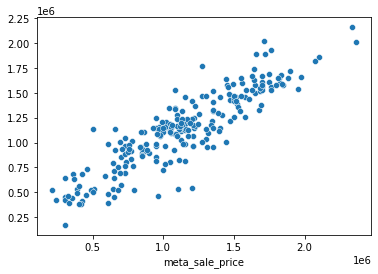

In [35]:
sns.scatterplot(x=y_train,y=y_tr_pred)

<AxesSubplot:xlabel='meta_sale_price'>

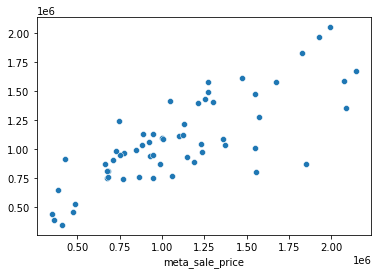

In [36]:
sns.scatterplot(x=y_test,y=y_te_pred)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

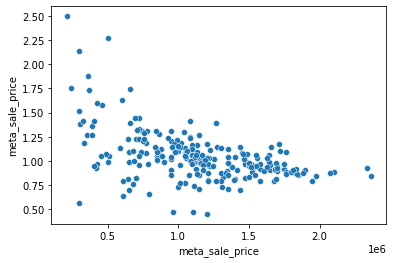

In [37]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

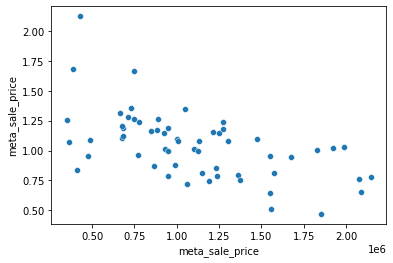

In [38]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

In [39]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0491360566949972, 1.0671990691429285)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

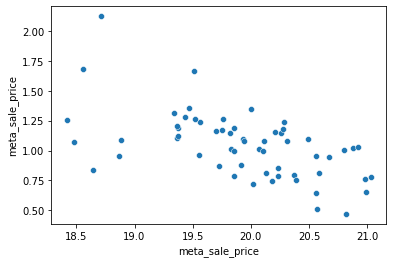

In [40]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

For linear regression, doubling the home price means the ratio goes down by almost 14%. Can this be improved with Random Forest?

In [41]:
rf = RandomForestRegressor(random_state=42)


In [42]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [43]:
y_tr_pred = rf.predict(X_train)
y_te_pred = rf.predict(X_test)

In [44]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)


(0.06442975083782056,
 0.16593440504167206,
 0.9693109759572004,
 0.6581567104554906,
 76158.67191183235,
 269554.02378348476,
 54845.34183760683,
 169893.10016949152)

In [45]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(6.412962466668047, 16.539561747999795)

variance compared to linear regression is reduced from 19% to 17%.

In [46]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0214769359887668, 1.0674456254461802)

prd is not inproved. Linear regression is better.

In [47]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.09603153]), array([-0.20900107]))

prb is also not improved. Can we improve Random Forest with hyperparameter tuning?

In [48]:
rfr= RandomForestRegressor(random_state=42)
params = {'n_estimators':[100,200,300,400,500],'criterion':["squared_error", "absolute_error", "poisson"],'max_features':["auto","sqrt","log2"]}
rfr_gscv = GridSearchCV(rfr,params,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")

In [49]:
rfr_gscv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_percentage_error')

In [50]:
y_tr_pred = rfr_gscv.predict(X_train)
y_te_pred = rfr_gscv.predict(X_test)

In [51]:
mape(y_train, y_tr_pred),mape(y_test, y_te_pred)


(0.06492994670308033, 0.16114012767962513)

In [52]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(6.447629908619754, 16.054056914393566)

In [53]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0221905061278458, 1.0675370278338763)

In [54]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.10026823]), array([-0.20560427]))

In [55]:
rfr_gscv.best_params_

{'criterion': 'absolute_error', 'max_features': 'auto', 'n_estimators': 100}

In [56]:
rfrbest= RandomForestRegressor(criterion='absolute_error',max_features='auto',n_estimators=100)
rfrbest.fit(X_train,y_train)

RandomForestRegressor(criterion='absolute_error')

In [57]:
y_tr_pred = rfrbest.predict(X_train)
y_te_pred = rfrbest.predict(X_test)

In [58]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.06717451613216592,
 0.16988602638019212,
 0.9694995139602692,
 0.6387202575344343,
 75924.37112031505,
 277111.2101932224,
 55046.02952991453,
 173081.008220339)

not an improvement.


In [59]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(6.670239467689324, 17.135999976406104)

small imporvement in cod

In [60]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0238658434358907, 1.071010205898244)

prd is worse

In [61]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.10708387]), array([-0.22009753]))

prb is also worse. Conclusion: minimizing root mean square error increases the bias in favor of the wealthy. Straight linear regression was the best of the models studied.

Below are graphs of the ratio metrics for the last model studied.

<AxesSubplot:xlabel='meta_sale_price'>

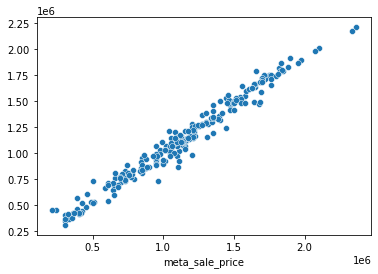

In [62]:
sns.scatterplot(x=y_train,y=y_tr_pred)

looks good on training data

<AxesSubplot:xlabel='meta_sale_price'>

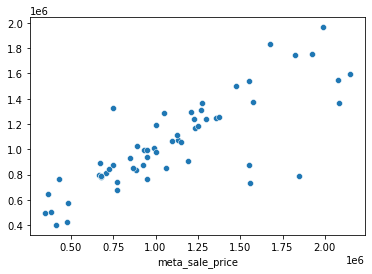

In [63]:
sns.scatterplot(x=y_test,y=y_te_pred)

less good on the test data

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

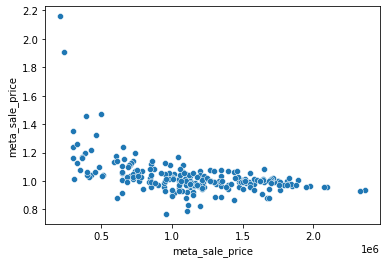

In [64]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

training data ratio is higher for low priced homes. The smallest priced home is valued at twice its sales price.

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

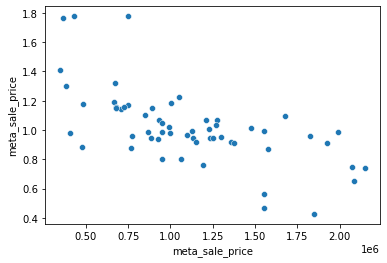

In [65]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

same bias in the test data

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

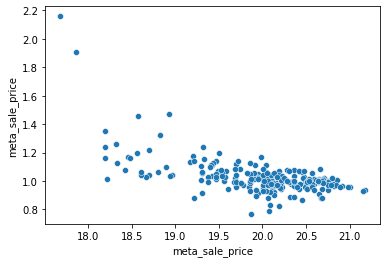

In [66]:
sns.scatterplot(x=np.log2(y_train),y=y_tr_pred/y_train)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

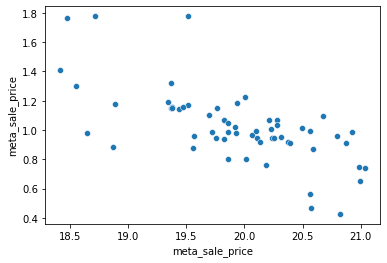

In [67]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

One can also see the downward trend in when graphing against the log of the price. One high priced homes are valued at less than half of its sale price.

In [68]:
gb = GradientBoostingRegressor(random_state=42)
params = {'n_estimators':[300,400,500],'learning_rate':[0.01,0.1,0.2],'loss':['squared_error', 'absolute_error'],'max_depth':[1,2,3]}
gb_gscv = GridSearchCV(gb,params,n_jobs=-1,cv=5,scoring="neg_mean_absolute_percentage_error")

In [69]:
gb_gscv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'loss': ['squared_error', 'absolute_error'],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [300, 400, 500]},
             scoring='neg_mean_absolute_percentage_error')

In [70]:
y_tr_pred = gb_gscv.predict(X_train)
y_te_pred = gb_gscv.predict(X_test)

In [71]:
mape(y_train, y_tr_pred), mape(y_test, y_te_pred),\
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred),\
np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred)),\
mean_absolute_error(y_train, y_tr_pred),mean_absolute_error(y_test, y_te_pred)

(0.11106099590478939,
 0.1645009548544317,
 0.8656963980412377,
 0.6874340591840851,
 159320.49736221708,
 257752.63634831482,
 107173.15192738427,
 179623.6915482913)

In [72]:
cod(y_tr_pred,y_train), cod(y_te_pred,y_test)

(11.10616998080721, 16.948916093147552)

In [73]:
prd(y_tr_pred,y_train), prd(y_te_pred,y_test)

(1.0298937480163681, 1.0496991435574823)

In [74]:
prb(y_tr_pred,y_train), prb(y_te_pred,y_test)

(array([-0.08902108]), array([-0.09950098]))

In [75]:
gb_gscv.best_params_

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 1,
 'n_estimators': 400}

<AxesSubplot:xlabel='meta_sale_price'>

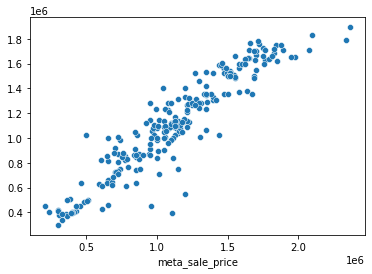

In [76]:
sns.scatterplot(x=y_train,y=y_tr_pred)

<AxesSubplot:xlabel='meta_sale_price'>

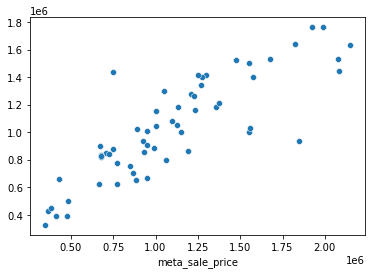

In [77]:
sns.scatterplot(x=y_test,y=y_te_pred)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

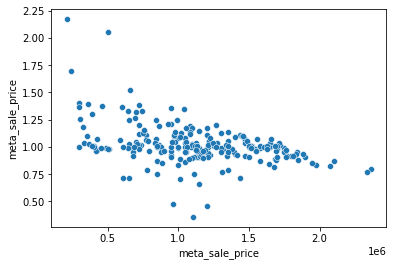

In [78]:
sns.scatterplot(x=y_train,y=y_tr_pred/y_train)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

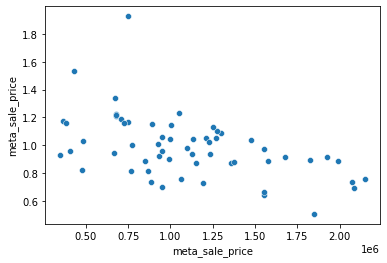

In [79]:
sns.scatterplot(x=y_test,y=y_te_pred/y_test)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

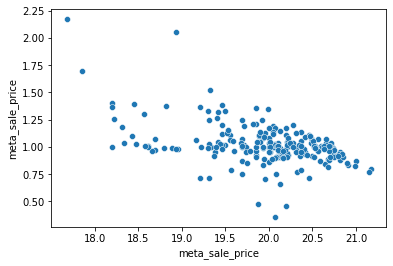

In [80]:
sns.scatterplot(x=np.log2(y_train),y=y_tr_pred/y_train)

<AxesSubplot:xlabel='meta_sale_price', ylabel='meta_sale_price'>

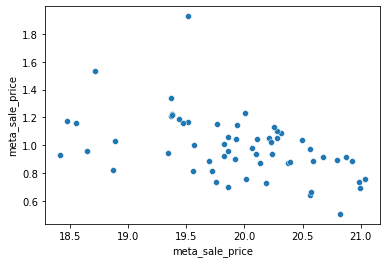

In [81]:
sns.scatterplot(x=np.log2(y_test),y=y_te_pred/y_test)

In [82]:
lr_wqd = RandomForestRegressor(random_state=42)
lr_wqd.fit(bell_X, bell_y)

RandomForestRegressor(random_state=42)

In [83]:
bell_2020 = pd.read_csv('../data/bell_cleaned.csv')
bell_2020['one_story'] = [1 if x < 205 else 0 for x in bell_2020['meta_class']]
bell_2020['row_house'] = [1 if ((x == 210) or (x==295)) else 0 for x in bell_2020['meta_class']]
bell_2020 = bell_2020.drop(columns='meta_class')
bell_2020_pin = bell_2020.meta_pin
bell_2020 = bell_2020.drop(['Unnamed: 0','meta_pin'],axis=1)

In [84]:
bell_wqd_pred = lr_wqd.predict(bell_2020)

In [85]:
qd_index= bell_sales[(bell_sales.one_story==1) &(bell_sales.meta_sale_price>700000)].index

In [86]:
bell_sales_woqd = bell_sales.drop(index = qd_index)

In [101]:
bell_sales[(bell_sales.one_story==1) &(bell_sales.meta_sale_price>700000)]

,Unnamed: 0,meta_pin,meta_year,meta_sale_price,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house
11,126589,13242040090000,2013.0,960000.0,4125.0,89.0,6.0,3.0,0.0,1.0,0.0,1164.0,-87.689760,41.951903,1,0
13,126591,13242040100000,2014.0,956000.0,4125.0,3.0,8.0,3.0,1.0,3.0,1.0,2467.0,-87.689638,41.951904,1,0
28,126606,13242050240000,2016.0,1200000.0,4125.0,93.0,6.0,3.0,1.0,1.0,0.0,1160.0,-87.689472,41.950610,1,0
30,126608,13242050270000,2014.0,850000.0,4125.0,91.0,7.0,5.0,0.0,2.0,0.0,2442.0,-87.689109,41.950612,1,0
52,126630,13242080130000,2014.0,1105000.0,3720.0,56.0,5.0,3.0,0.0,2.0,0.0,1008.0,-87.690370,41.947411,1,0
97,143218,14191010110000,2015.0,737500.0,3720.0,92.0,8.0,3.0,0.0,2.0,1.0,2291.0,-87.686894,41.953311,1,0
113,143251,14191050140000,2015.0,727000.0,3720.0,112.0,7.0,4.0,0.0,2.0,1.0,2268.0,-87.682012,41.952887,1,0
159,143340,14191110160000,2017.0,950000.0,3720.0,114.0,7.0,3.0,0.0,2.0,0.0,1836.0,-87.684370,41.950889,1,0
161,143346,14191120050000,2014.0,725000.0,3596.0,111.0,7.0,4.0,0.0,1.0,0.0,1816.0,-87.683192,41.951820,1,0
176,143382,14191140110000,2015.0,775000.0,4340.0,112.0,6.0,3.0,0.0,1.0,1.0,2048.0,-87.680752,41.951201,1,0


In [87]:
bell_woqd_pin = bell_sales_woqd.meta_pin
bell_woqd_y = bell_sales_woqd.meta_sale_price
bell_woqd_X = bell_sales_woqd.drop(['Unnamed: 0','meta_pin','meta_sale_price','meta_class'],axis=1)

In [88]:
bell_woqd_X.head()

,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house
0,2017.0,3050.0,18.0,8.0,4.0,0.0,2.0,1.0,2340.0,-87.690565,41.953323,0,0
1,2013.0,3050.0,2.0,9.0,4.0,3.0,3.0,1.0,2639.0,-87.690473,41.953324,0,0
2,2013.0,3137.0,54.0,6.0,3.0,0.0,2.0,0.0,1020.0,-87.690731,41.952804,1,0
3,2014.0,3050.0,116.0,4.0,2.0,0.0,2.0,0.0,680.0,-87.690547,41.952805,1,0
4,2018.0,3660.0,96.0,7.0,4.0,1.0,2.0,1.0,2778.0,-87.689729,41.952810,0,0


In [89]:
bell_2020.head()

,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house
0,2020.0,3129.0,25.0,10.0,3.0,2.0,3.0,1.0,2166.0,-87.690749,41.953322,0,0
1,2020.0,3050.0,127.0,4.0,3.0,0.0,1.0,0.0,1077.0,-87.690657,41.953323,1,0
2,2020.0,3050.0,21.0,8.0,4.0,0.0,2.0,1.0,2340.0,-87.690565,41.953323,0,0
3,2020.0,3050.0,9.0,9.0,4.0,2.0,3.0,1.0,2639.0,-87.690473,41.953324,0,0
4,2020.0,3050.0,96.0,7.0,3.0,0.0,2.0,1.0,2350.0,-87.690197,41.953325,0,0


In [90]:
lr_woqd = RandomForestRegressor(random_state=42)
lr_woqd.fit(bell_woqd_X, bell_woqd_y)
bell_woqd_pred = lr_woqd.predict(bell_2020)

In [91]:
bell_2020['pin']=bell_2020_pin
bell_2020['pred_wqd'] = bell_wqd_pred
bell_2020['pred_woqd'] = bell_woqd_pred

In [92]:
bung_pins =[13242050060000,13242050080000,13242050100000,13242050110000,13242050130000]
bell_2020[bell_2020.pin.isin(bung_pins)]

,meta_year,char_hd_sf,char_age,char_rooms,char_beds,char_frpl,char_fbath,char_hbath,char_bldg_sf,geo_longitude,geo_latitude,one_story,row_house,pin,pred_wqd,pred_woqd
58,2020.0,4125.0,96.0,6.0,3.0,0.0,1.0,0.0,1116.0,-87.690093,41.950991,1,0,13242050060000,530596.0,534449.5
60,2020.0,4125.0,95.0,7.0,4.0,0.0,1.0,0.0,1183.0,-87.689850,41.950993,1,0,13242050080000,572793.5,515739.5
62,2020.0,4125.0,96.0,6.0,3.0,0.0,2.0,0.0,1920.0,-87.689608,41.950995,1,0,13242050100000,580217.5,517977.0
63,2020.0,4125.0,96.0,4.0,3.0,0.0,2.0,0.0,1383.0,-87.689487,41.950996,1,0,13242050110000,592430.0,519126.0
65,2020.0,4125.0,93.0,6.0,3.0,1.0,2.0,0.0,1853.0,-87.689245,41.950997,1,0,13242050130000,838968.5,523721.0


array([[<AxesSubplot:title={'center':'char_age'}>]], dtype=object)

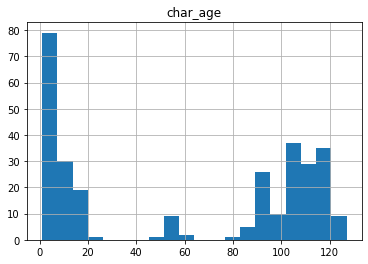

In [93]:
bell_sales.hist(column='char_age',bins=20)

In [94]:
bell_sales[bell_sales.char_age<40].shape


(129, 17)

In [95]:
bell_sales[bell_sales.char_age>70].shape


(152, 17)

In [96]:
bell_sales[bell_sales.char_age<70].shape


(141, 17)

In [97]:
bell_sales['one_story'] = [1 if x < 205 else 0 for x in bell_sales['meta_class']]
bell_sales['row_house'] = [1 if ((x == 210) or (x==295)) else 0 for x in bell_sales['meta_class']]
bell_sales = bell_sales.drop(columns='meta_class')
bell_new = bell_sales[bell_sales.char_age<70]
bell_old = bell_sales[bell_sales.char_age>70]
old_y = bell_old.meta_sale_price
old_X = bell_old.drop(['Unnamed: 0','meta_pin','meta_sale_price'],axis=1)
new_y = bell_new.meta_sale_price
new_X = bell_new.drop(['Unnamed: 0','meta_pin','meta_sale_price'],axis=1)

In [98]:
oldX_train, oldX_test, oldy_train, oldy_test = train_test_split(old_X, old_y, test_size=0.2, random_state=42)
newX_train, newX_test, newy_train, newy_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

In [99]:
oldscaler = StandardScaler()
oldscaler.fit(oldX_train)
oldX_train= scaler.transform(oldX_train)
oldX_test = scaler.transform(oldX_test)
newscaler = StandardScaler()
newscaler.fit(newX_train)
newX_train= scaler.transform(newX_train)
newX_test = scaler.transform(newX_test)